# 1. Molecular similarity

In [1]:
%pwd

'/Users/macbook/Desktop/Desktop/Long/Similarity/Apelin'

In [2]:
from pathlib import Path
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools, AllChem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

import os
import seaborn as sns
sns.set(style ='darkgrid')


#from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams


from rdkit import Chem, DataStructs
from rdkit.Chem import (
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys,
    rdFingerprintGenerator,)


data = pd.read_csv("Data_apelin.csv", index_col=None)
data.drop(["Unnamed: 0"], axis = 1, inplace = True)
data.head()

,ID,Canomial_smiles,active
0,US9156796B2_11,CCC(CC)n1c(Cc2cccs2)nc2cc(C(=O)NC(CC3CCCC3)C(=...,1
1,US9156796B2_22,CCC(CC)n1c(Cc2cccs2)nc2cc(C(=O)N[C@@H](CC3CCC3...,1
2,US9156796B2_53,CC[C@H](C)[C@@H](CC(=O)O)NC(=O)c1ccc2c(c1)nc(C...,1
3,US9156796B2_60,CCC(CC)n1c(Cc2cccs2)nc2cc(C(=O)N[C@H](CC(=O)O)...,1
4,US9156796B2_61,C[C@@H]1CCCC[C@H]1n1c(Cc2cccs2)nc2cc(C(=O)N[C@...,1


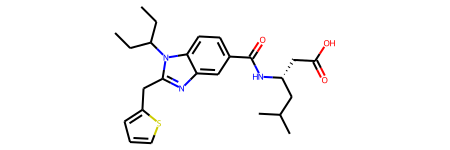

In [3]:
import seaborn as sns
base = "CCC(CC)n1c(Cc2cccs2)nc2cc(C(=O)N[C@H](CC(=O)O)CC(C)C)ccc21"
#data.drop(index = 1504, inplace = True)
query = Chem.MolFromSmiles(base)
query

In [9]:
idx = data[data.Canomial_smiles==base].index.values
data.drop(idx, axis =0, inplace = True)
data.reset_index(drop = True, inplace = True)

In [10]:
class Molecule_similarity:
    """
    Vẫn không display được hàm Chem.Draw.MolsToGridImage
    """
    def __init__(self, data, query, smile_col, active_col):
        self.data = data
        self.query = query
        self.smile_col = smile_col
        self.active_col = active_col
        PandasTools.AddMoleculeColumnToFrame(self.data, smilesCol = self.smile_col)
        
    def fingerprint(self):
        self.maccs_fp_query = MACCSkeys.GenMACCSKeys(self.query)
        self.circular_fp_query = rdFingerprintGenerator.GetCountFPs([self.query])[0]
        #self.circular_fp_query = AllChem.GetMorganFingerprintAsBitVect(self.query, 2, nBits=1024)
        self.rdkf_fp_query = Chem.RDKFingerprint(self.query)
        
        self.circular_fp_list = rdFingerprintGenerator.GetCountFPs(data["ROMol"].tolist())
        self.maccs_fp_list = data["ROMol"].apply(MACCSkeys.GenMACCSKeys).tolist()
        #self.circular_fp_list = data["ROMol"].apply(GetMorganFingerprintAsBitVect).tolist()
        self.rdkf_list = data["ROMol"].apply(Chem.RDKFingerprint).tolist()
        
    def Coef(self):
        self.data["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(
            self.maccs_fp_query, self.maccs_fp_list
        )
        self.data["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(
            self.circular_fp_query, self.circular_fp_list
        )
        self.data["tanimoto_rdkf"] = DataStructs.BulkTanimotoSimilarity(
            self.rdkf_fp_query, self.rdkf_list
        )

        self.data["dice_maccs"] = DataStructs.BulkDiceSimilarity(self.maccs_fp_query, self.maccs_fp_list)
        self.data["dice_morgan"] = DataStructs.BulkDiceSimilarity(
            self.circular_fp_query, self.circular_fp_list
        )
        self.data["dice_rdkf"] = DataStructs.BulkDiceSimilarity(self.rdkf_fp_query, self.rdkf_list)
        
        #self.data["Tversky_maccs"] = DataStructs.BulkTverskySimilarity(self.maccs_fp_query, self.maccs_fp_list, alpha  = 0.1, beta = 0.9)
        #self.data["Tversky_morgan"] = DataStructs.BulkTverskySimilarity(self.circular_fp_query, self.circular_fp_list, alpha  = 0.1, beta = 0.9)
        #self.data["Tversky_rdkf"] = DataStructs.BulkTverskySimilarity(self.rdkf_fp_query, self.rdkf_list, alpha  = 0.1, beta = 0.9)
        
        
    def fit(self):
        self.fingerprint()
        self.Coef()
        
        display(data[[self.smile_col, "tanimoto_maccs", "tanimoto_morgan","tanimoto_rdkf", 
                      "dice_maccs", "dice_morgan", "dice_rdkf",
                      #"Tversky_maccs", "Tversky_morgan", "Tversky_rdkf",
                      self.active_col]].head(5))
        
    def plot(self):
        fig, axes = plt.subplots(figsize=(18, 9), nrows=2, ncols=3)
       
        sns.histplot(data = self.data, x=self.data["tanimoto_maccs"],hue=self.data[self.active_col], ax=axes[0, 0], kde = True, )
        sns.histplot(data = self.data, x=self.data["tanimoto_morgan"],hue=self.data[self.active_col], ax=axes[0, 1],kde = True, )
        sns.histplot(data = self.data, x=self.data["tanimoto_rdkf"], hue=self.data[self.active_col],ax=axes[0, 2],kde = True,)
        
        sns.histplot(data = self.data, x=self.data["dice_maccs"], hue=self.data[self.active_col],ax=axes[1, 0], kde = True, )
        sns.histplot(data = self.data, x=self.data["dice_morgan"], hue=self.data[self.active_col],ax=axes[1, 1],kde = True, )
        sns.histplot(data = self.data, x=self.data["dice_rdkf"],hue=self.data[self.active_col], ax=axes[1, 2],kde = True,)
        
        #sns.histplot(self.data["Tversky_maccs"], ax=axes[2, 0], kde = True, color ='lightcoral')
        #sns.histplot(self.data["Tversky_morgan"], ax=axes[2, 1],kde = True, color = 'steelblue')
        #sns.histplot(self.data["Tversky_rdkf"], ax=axes[2, 2],kde = True,color = 'darkcyan')
        
        #axes[1, 0].set_xlabel("similarity value")
        #axes[1, 0].set_ylabel("# molecules")
        fig.savefig("Compare_1.png", transparent = True, dpi = 600)
        fig;
        
        fig, axes = plt.subplots(figsize=(18, 6), nrows=1, ncols=3)

        self.data.plot("tanimoto_maccs", "dice_maccs", kind="scatter", ax=axes[0])
        axes[0].plot([0, 1], [0, 1], "k--")
        axes[0].set_xlabel("Tanimoto (MACCS)")
        axes[0].set_ylabel("Dice (MACCS)")

        self.data.plot("tanimoto_morgan", "dice_morgan", kind="scatter", ax=axes[1])
        axes[1].plot([0, 1], [0, 1], "k--")
        axes[1].set_xlabel("Tanimoto (Morgan)")
        axes[1].set_ylabel("Dice (Morgan)")
        
        self.data.plot("tanimoto_rdkf", "dice_rdkf", kind="scatter", ax=axes[2])
        axes[2].plot([0, 1], [0, 1], "k--")
        axes[2].set_xlabel("Tanimoto (RDKF)")
        axes[2].set_ylabel("Dice (RDKF)")
        #fig.savefig("Compare_2.png", transparent = True, dpi = 600)

        fig;
    def display_mol(self):
        top_n_molecules = 10
        top_molecules = self.data.sort_values(["tanimoto_morgan"], ascending=False).reset_index()
        top_molecules = top_molecules[:top_n_molecules]
        legends = [
            f"#{index+1} {molecule[self.active_col]}, pIC50={molecule[self.active_col]:.2f}"
            for index, molecule in top_molecules.iterrows()
        ]
        img = Chem.Draw.MolsToGridImage(
            mols=[query] + top_molecules["ROMol"].tolist(),
            legends=(["Base"] + legends),
            molsPerRow=3,
            subImgSize=(450, 150),useSVG=True,
        )
        display(img),

,Canomial_smiles,tanimoto_maccs,tanimoto_morgan,tanimoto_rdkf,dice_maccs,dice_morgan,dice_rdkf,active
0,CCC(CC)n1c(Cc2cccs2)nc2cc(C(=O)NC(CC3CCCC3)C(=...,0.793651,0.648649,0.902542,0.884956,0.786885,0.948775,1
1,CCC(CC)n1c(Cc2cccs2)nc2cc(C(=O)N[C@@H](CC3CCC3...,0.781250,0.672897,0.907155,0.877193,0.804469,0.951318,1
2,CC[C@H](C)[C@@H](CC(=O)O)NC(=O)c1ccc2c(c1)nc(C...,0.859375,0.554622,0.934764,0.924370,0.713514,0.966282,1
3,CCC(CC)n1c(Cc2cccs2)nc2cc(C(=O)N[C@H](CC(=O)O)...,0.883333,0.738318,0.975022,0.938053,0.849462,0.987353,1
4,C[C@@H]1CCCC[C@H]1n1c(Cc2cccs2)nc2cc(C(=O)N[C@...,0.841270,0.484615,0.936590,0.913793,0.652850,0.967257,1


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


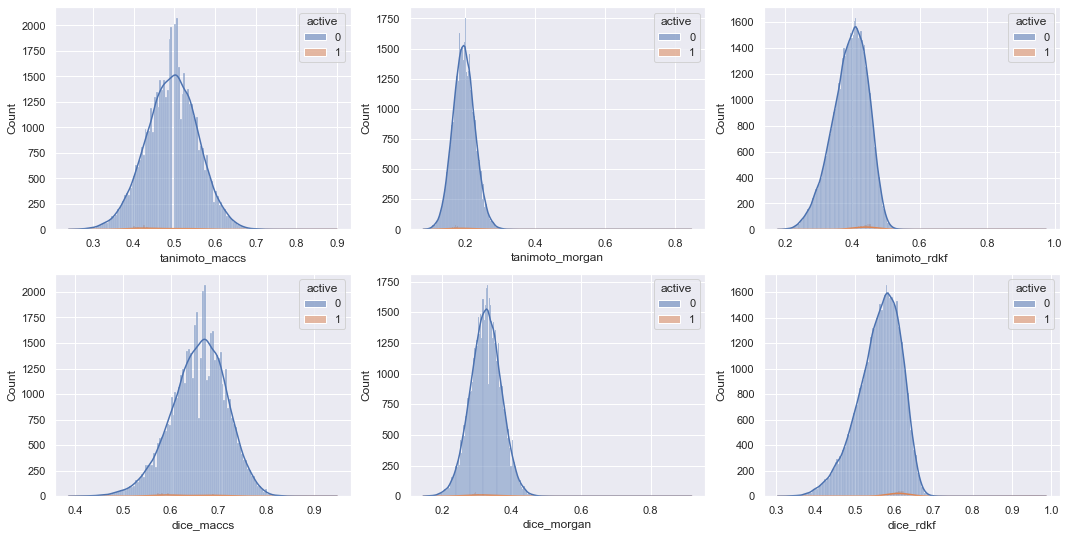

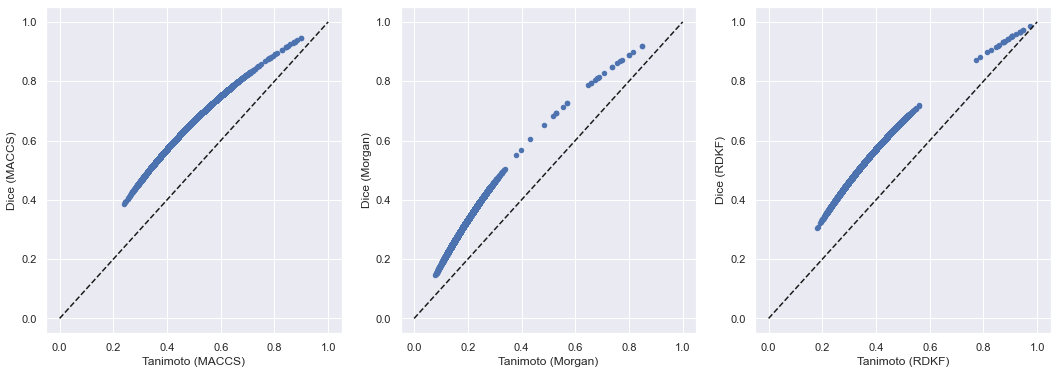

In [11]:
s = Molecule_similarity(data = data, query= query, smile_col="Canomial_smiles", active_col='active')
s.fit()
s.plot()

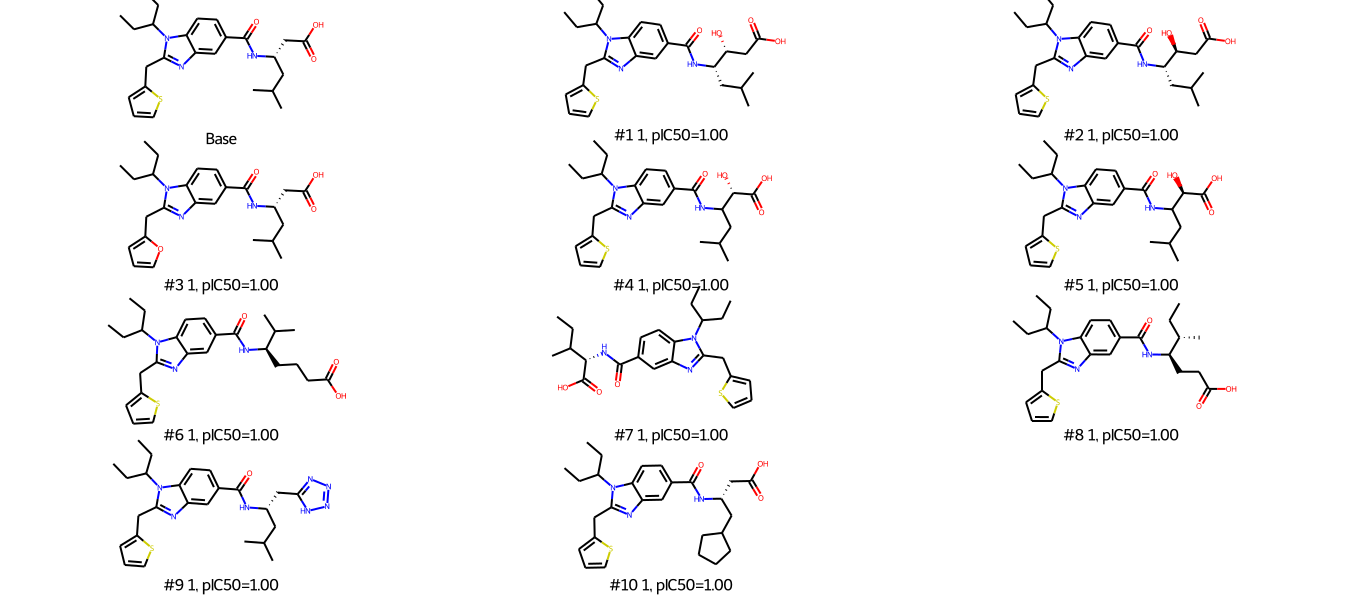

In [13]:
s.display_mol()

# 2. Similarity Map

https://greglandrum.github.io/rdkit-blog/tutorial/2020/01/03/similarity-maps-with-new-drawing-code.html

In [29]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from IPython.display import SVG
import io
from PIL import Image
import numpy as np
import rdkit
print(rdkit.__version__)

2022.03.1


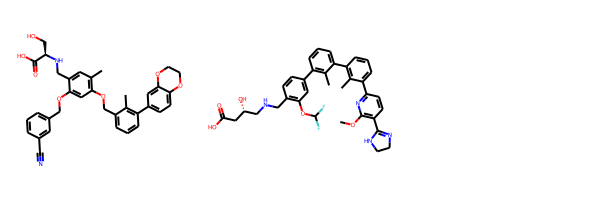

In [30]:
atorvastatin = query
rosuvastatin = Chem.MolFromSmiles(s.data.Smiles[0])
Draw.MolsToGridImage((atorvastatin,rosuvastatin))

In [31]:
class Similarity_Map:
    def __init__(self, query, base):
        self.query = query
        self.base = base
    
    
    def show_png(data):
        bio = io.BytesIO(data)
        img = Image.open(bio)
        return img
    
    def similarity_map_bitvect(self):
        d = Draw.MolDraw2DCairo(400, 400)
        _, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(self.query, self.base, 
                                                                     lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='bv'), 
                                                                     draw2d=d)
        d.FinishDrawing()
        display(show_png(d.GetDrawingText()))
        
    def similarity_map_countvect(self):
        d = Draw.MolDraw2DCairo(400, 400)
        _, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(self.query, self.base, 
                                                                     lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='count'), 
                                                                     draw2d=d)
        d.FinishDrawing()
        display(show_png(d.GetDrawingText()))

In [32]:
f = Similarity_Map(atorvastatin, rosuvastatin)
f.similarity_map_bitvect()
f.similarity_map_countvect()

RuntimeError: Pre-condition Violation
	no draw context
	Violation occurred on line 203 in file Code/GraphMol/MolDraw2D/MolDraw2DCairo.cpp
	Failed Expression: dp_cr
	RDKIT: 2022.03.1
	BOOST: 1_75


In [64]:
data_out.to_csv("data_roc.csv")

# 3. Enrichment factor

In [14]:
class Enrichment_Factor:
    
    def __init__(self,data, similarity_measure, pBio_cutoff, bioactivity, ranked_dataset_percentage_cutoff):
        self.data = data
        self.similarity_measure = similarity_measure
        self.pBio_cutoff = pBio_cutoff
        self.bioactivity = bioactivity
        self.ranked_dataset_percentage_cutoff = ranked_dataset_percentage_cutoff
    
    # 1. Enrichment_data
    def get_enrichment_data(self, similarity_measure):
        """
        Calculates x and y values for enrichment plot:
            x - % ranked dataset
            y - % true actives identified

        Parameters
        ----------
        molecules : pandas.DataFrame
            Molecules with similarity values to a query molecule.
        similarity_measure : str
            Column name which will be used to sort the DataFrame．
        pic50_cutoff : float
            pIC50 cutoff value used to discriminate active and inactive molecules.

        Returns
        -------
        pandas.DataFrame
            Enrichment data: Percentage of ranked dataset by similarity vs. percentage of identified true actives.
        """

        # Get number of molecules in data set
        molecules_all = len(self.data)

        # Get number of active molecules in data set
        actives_all = sum(self.data[self.bioactivity] >= self.pBio_cutoff)

        # Initialize a list that will hold the counter for actives and molecules while iterating through our dataset
        actives_counter_list = []

        # Initialize counter for actives
        actives_counter = 0

        # Note: Data must be ranked for enrichment plots:
        # Sort molecules by selected similarity measure
        self.data.sort_values([similarity_measure], ascending=False, inplace=True)

        # Iterate over the ranked dataset and check each molecule if active (by checking bioactivity)
        for value in self.data[self.bioactivity]:
            if value >= self.pBio_cutoff:
                actives_counter += 1
            actives_counter_list.append(actives_counter)

        # Transform number of molecules into % ranked dataset
        molecules_percentage_list = [i / molecules_all for i in range(1, molecules_all + 1)]

        # Transform number of actives into % true actives identified
        actives_percentage_list = [i / actives_all for i in actives_counter_list]

        # Generate DataFrame with x and y values as well as label
        self.enrichment = pd.DataFrame(
            {
                "% ranked dataset": molecules_percentage_list,
                "% true actives identified": actives_percentage_list,
            }
        )

        return self.enrichment
    # 2. Get EF data
    def EF(self):
        self.enrichment_data = {
            similarity_measure: self.get_enrichment_data(similarity_measure)
            for similarity_measure in self.similarity_measure}
        print("TANIMOTO MACCS")
        display(self.enrichment_data["tanimoto_maccs"].head())
        print("TANIMOTO MORGAN")
        display(self.enrichment_data["tanimoto_morgan"].head())
        print("TANIMOTO RDKF")
        display(self.enrichment_data["tanimoto_rdkf"].head())
      
    # 3. Calculate enrichment_factor for dataset
    def calculate_enrichment_factor(self, enrichment):
        """
        Get the experimental enrichment factor for a given percentage of the ranked dataset.

        Parameters
        ----------
        enrichment : pd.DataFrame
            Enrichment data: Percentage of ranked dataset by similarity vs. percentage of
            identified true actives.
        ranked_dataset_percentage_cutoff : float or int
            Percentage of ranked dataset to be included in enrichment factor calculation.

        Returns
        -------
        float
            Experimental enrichment factor.
        """

        # Keep only molecules that meet the cutoff
        enrichment = enrichment[
            enrichment["% ranked dataset"] <= self.ranked_dataset_percentage_cutoff / 100
        ]
        # Get highest percentage of actives and the corresponding percentage of actives
        highest_enrichment = enrichment.iloc[-1]
        enrichment_factor = round(100 * float(highest_enrichment["% true actives identified"]), 1)
        return enrichment_factor
    
    # 4. Calculate random enrichment_factor for dataset
    def calculate_enrichment_factor_random(self):
        """
        Get the random enrichment factor for a given percentage of the ranked dataset.

        Parameters
        ----------
        ranked_dataset_percentage_cutoff : float or int
            Percentage of ranked dataset to be included in enrichment factor calculation.

        Returns
        -------
        float
            Random enrichment factor.
        """

        enrichment_factor_random = round(float(self.ranked_dataset_percentage_cutoff), 1)
        return enrichment_factor_random
    
    # 5. Calculate optimal enrichment_factor for dataset
    def calculate_enrichment_factor_optimal(self):
        """
        Get the optimal random enrichment factor for a given percentage of the ranked dataset.

        Parameters
        ----------
        molecules : pandas.DataFrame
            the DataFrame with all the molecules and pIC50.
        ranked_dataset_percentage_cutoff : float or int
            Percentage of ranked dataset to be included in enrichment factor calculation.
        activity_cutoff: float
            pIC50 cutoff value used to discriminate active and inactive molecules

        Returns
        -------
        float
            Optimal enrichment factor.
        """

        ratio = sum(self.data[self.bioactivity] >= pBio_cutoff) / len(self.data) * 100
        if self.ranked_dataset_percentage_cutoff <= ratio:
            enrichment_factor_optimal = round(100 / ratio * self.ranked_dataset_percentage_cutoff, 1)
        else:
            enrichment_factor_optimal = 100.0
        return enrichment_factor_optimal
    
    # 6. Calculate all enrichment_factor for dataset
    def EF_calculate(self):
        for similarity_measure, enrichment in self.enrichment_data.items():
            enrichment_factor = self.calculate_enrichment_factor(enrichment)
            print(
                f"Experimental EF for {self.ranked_dataset_percentage_cutoff}% of ranked dataset ({similarity_measure}): {enrichment_factor}%"
            )
        enrichment_factor_random = self.calculate_enrichment_factor_random()
        print(
            f"Random EF for {self.ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_random}%"
        )
        enrichment_factor_optimal = self.calculate_enrichment_factor_optimal()
        print(
            f"Optimal EF for {self.ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_optimal}%"
        )

    # 7. Plot the enrichment data next to the optimal and random enrichment curve!
    def plot_EF(self):
        
        fig, ax = plt.subplots(figsize=(6, 6))

        fontsize = 20

        # Plot enrichment data
        for similarity_measure, enrichment in self.enrichment_data.items():
            ax = enrichment.plot(
                ax=ax,
                x="% ranked dataset",
                y="% true actives identified",
                label=similarity_measure,
                alpha=0.5,
                linewidth=4,
            )
        ax.set_ylabel("% True actives identified", size=fontsize)
        ax.set_xlabel("% Ranked dataset", size=fontsize)

        # Plot optimal curve: Ratio of actives in dataset
        ratio_actives = sum(self.data[self.bioactivity] >= self.pBio_cutoff) / len(data)
        ax.plot(
            [0, ratio_actives, 1],
            [0, 1, 1],
            label="Optimal curve",
            color="black",
            linestyle="--",
        )

        # Plot random curve
        ax.plot([0, 1], [0, 1], label="Random curve", color="red", linestyle="--")

        plt.tick_params(labelsize=16)
        plt.legend(
            labels=["MACCS", "Morgan", "RDKF", "Optimal", "Random"],
            loc=(0.5, 0.08),
            fontsize=fontsize,
            labelspacing=0.3,
        )

        # Save plot -- use bbox_inches to include text boxes
        plt.savefig(
            "enrichment_plot.png",
            dpi=300,
            bbox_inches="tight",
            transparent=True,
        )

        plt.show()

TANIMOTO MACCS


,% ranked dataset,% true actives identified
0,0.000019,0.002119
1,0.000037,0.004237
2,0.000056,0.006356
3,0.000074,0.008475
4,0.000093,0.010593


TANIMOTO MORGAN


,% ranked dataset,% true actives identified
0,0.000019,0.002119
1,0.000037,0.004237
2,0.000056,0.006356
3,0.000074,0.008475
4,0.000093,0.010593


TANIMOTO RDKF


,% ranked dataset,% true actives identified
0,0.000019,0.002119
1,0.000037,0.004237
2,0.000056,0.006356
3,0.000074,0.008475
4,0.000093,0.010593


Experimental EF for 10% of ranked dataset (tanimoto_maccs): 9.3%
Experimental EF for 10% of ranked dataset (tanimoto_morgan): 13.3%
Experimental EF for 10% of ranked dataset (tanimoto_rdkf): 22.5%
Random EF for 10% of ranked dataset: 10.0%
Optimal EF for 10% of ranked dataset: 100.0%


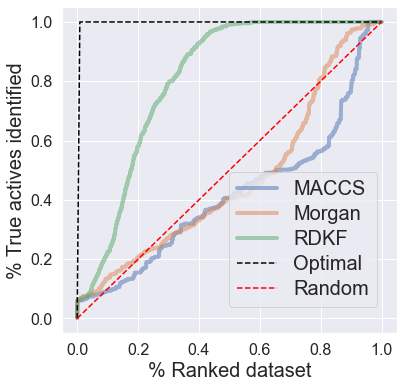

In [21]:
pBio_cutoff = .5
similarity_measures = ["tanimoto_maccs", "tanimoto_morgan", "tanimoto_rdkf"]
ef = Enrichment_Factor(data = s.data,similarity_measure=similarity_measures, pBio_cutoff=pBio_cutoff, 
                       bioactivity = 'active', ranked_dataset_percentage_cutoff = 10
                      )
ef.EF()
ef.EF_calculate()
ef.plot_EF()

# 4. ROC AUC

,ID,Canomial_smiles,active,ROMol,tanimoto_maccs,tanimoto_morgan,tanimoto_rdkf,dice_maccs,dice_morgan,dice_rdkf
0,US9156796B2_1,CCC(CC)n1c(Cc2cccs2)nc2cc(C(=O)NC3(C(=O)O)CCCC...,0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",0.746269,0.591304,0.884934,0.854701,0.743169,0.938955
1,US9156796B2_2,CCC(CC)n1c(Cc2ccco2)nc2cc(C(=O)NC(C)(Cc3ccccc3...,0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",0.757576,0.480315,0.706677,0.862069,0.648936,0.828132

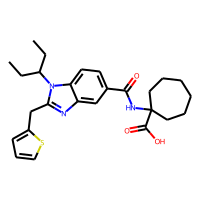
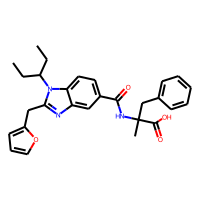

In [26]:
s.data.head(2)

In [17]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score,  roc_curve, auc, precision_recall_curve,average_precision_score
from sklearn.metrics import accuracy_score

fpr, tpr, _ = roc_curve(s.data['active'], s.data['tanimoto_maccs'])
roc_auc = round(auc(fpr, tpr),3)

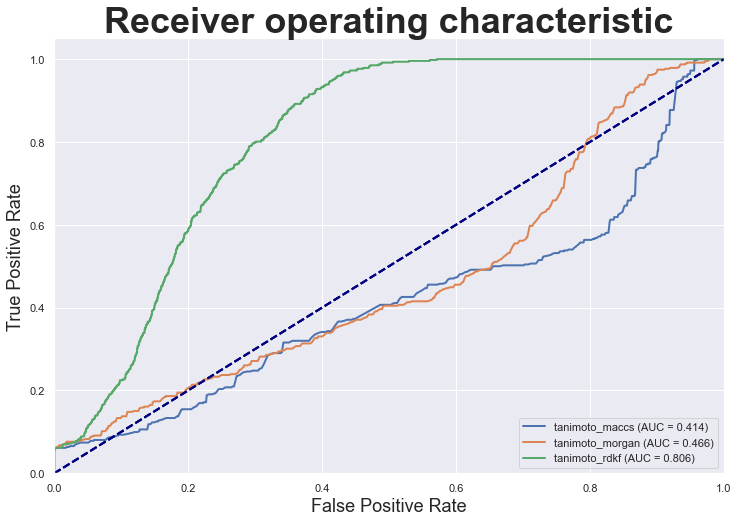

In [20]:
data_roc = s.data[['active', 'tanimoto_maccs','tanimoto_morgan','tanimoto_rdkf']]
plt.figure(figsize = (12,8))
for i in data_roc.drop(['active'], axis = 1).columns:
    fpr, tpr, _ = roc_curve(data_roc['active'], data_roc[i])
    roc_auc = round(auc(fpr, tpr),3)
    plot_roc(fpr, tpr, roc_auc, model = i)

In [38]:
s.data['tanimoto_maccs']

0       0.746269
1       0.757576
2       0.734375
3       0.809524
4       0.819672
          ...   
1068    0.411765
1069    0.432990
1070    0.442105
1071    0.437500
1072    0.432990
Name: tanimoto_maccs, Length: 1073, dtype: float64

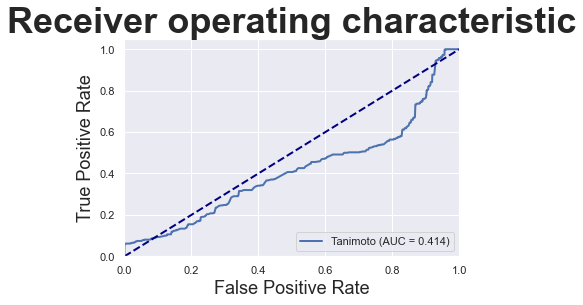

In [19]:
def plot_roc (fpr, tpr, auc, model):
        """ Calculates and plots and ROC and AUC.
        Parameters:
        actives_list - binary array of active/decoy status.
        score_list - array of experimental scores.
        """
        # Plot figure
        #sns.set('notebook', 'whitegrid', 'dark', font_scale=1.5, font='Ricty',
        #rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
        #plt.figure(figsize = (12,8))
        lw = 2
        plt.plot(fpr, tpr, 
                 lw=lw, label=f'{model} (AUC = %0.3f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize = 18)
        plt.ylabel('True Positive Rate', fontsize = 18)
        plt.title('Receiver operating characteristic', fontsize = 36, weight = 'semibold')
        plt.legend(loc="lower right")
        
plot_roc(fpr, tpr, roc_auc, model ='Tanimoto')

In [15]:
s.data.to_csv("data_roc.csv")